\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}
\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center}

# 1. {-}

## (a) {-}

Below we download the data to a DataFrame, run the $k$-means clustering with $K=5$ on the scaled data, and add the result back to the DataFrame. Most of the cheeses are put in the same cluster by the algorithm as expected. There are a few exceptions which we will take a closer look. 

In [2]:
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

# fulldata = pd.read_csv('http://rosmarus.refsmmat.com/datasets/datasets/nutrition/sr28_ABBREV.csv', index_col=0)

fulldata = pd.read_csv('sr28_ABBREV.csv', index_col=0).dropna()
data = fulldata[['Energ_Kcal', 'Protein', 'Lipid_Tot', 'Carbohydrt', 'Fiber_TD', 'Sugar_Tot', 'Cholestrl']]
scaled_data = scale(data)

fulldata['Cluster'] = KMeans(n_clusters=5).fit_predict(scaled_data)
fulldata[['Shrt_Desc', 'Cluster']][3:39]

,Shrt_Desc,Cluster
NDB_No,,
1004,"CHEESE,BLUE",0
1005,"CHEESE,BRICK",0
1006,"CHEESE,BRIE",0
1007,"CHEESE,CAMEMBERT",0
1009,"CHEESE,CHEDDAR",0
1011,"CHEESE,COLBY",0
1012,"CHEESE,COTTAGE,CRMD,LRG OR SML CURD",3
1013,"CHEESE,COTTAGE,CRMD,W/FRUIT",3
1014,"CHEESE,COTTAGE,NONFAT,UNCRMD,DRY,LRG OR SML CURD",3


The exceptions are cheeses with NDB_No 1012 - 1016 and 1037. Below is a line plot of the scaled data. Those exceptions all have lower ```Energ_Kcal```, ```Protein```, ```Lipid_Tot``` and ```Cholestrl``` than other types of cheese, most likely the reason they are in a different cluster. 

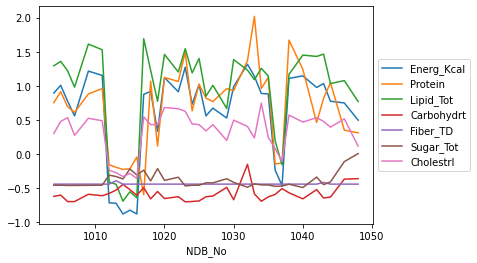

In [6]:
import hvplot.pandas
from pandas import DataFrame
import matplotlib.pyplot as plt

columns = data[3:39].columns
index = data[3:39].index

DataFrame(scaled_data[3:39], columns=columns, index=index).plot()   #.hvplot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## (b) {-}

Recall that 
\begin{align*}
W_K &= \min_{C, c_1, \ldots, c_K \in \mathbb R^p}\sum_{k=1}^K\sum_{C(i)=k}\lVert X_i - c_k \rVert_2^2, \\
W_{K+1} &= \min_{C, c_1, \ldots, c_K, c_{K+1} \in \mathbb R^p}\sum_{k=1}^{K+1}\sum_{C(i)=k}\lVert X_i - c_k \rVert_2^2. 
\end{align*}
Thus $W_K$ is the solution of the same optimization problem as $W_{K+1}$ but with one more constraint $c_K = c_{K+1}$. 
With this extra constraint, to find $W_K$ is to search the minimum in a solution space that is a subspace of $W_{K+1}$'s, so $W_K > W_{K+1}$.

## (c) {-}

It is not so much of a "kink" but judging from the below figure, $W_K$ starts to reduce slower after $K=11$ or so. 

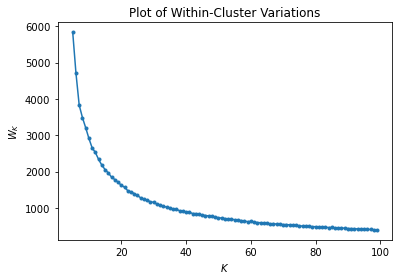

In [10]:
import matplotlib.pyplot as plt
from pandas import Series

ax = DataFrame([(K, KMeans(n_clusters=K).fit(scaled_data).inertia_) for K in range(5, 100)], columns=['K', 'W_K']).set_index('K').plot(style='.-', legend=None)
ax.set(xlabel='$K$', ylabel='$W_K$', title='Plot of Within-Cluster Variations')
plt.show()

## (d) {-}

We use the ```scipy.stats.uniform``` random number generator to generate null data. It takes ```loc``` and ```scale``` as input parameters, which we compute from each feature's maximum and minimum and store in a DataFrame.

In [4]:
from pandas import DataFrame

columns = data.columns
index = data.index

param = DataFrame(scaled_data, columns=columns, index=index).describe().loc[['min', 'max']].T
param['loc'] = param['min']
param['scale'] = param['max'] - param['min']
param = param.T
param

,Energ_Kcal,Protein,Lipid_Tot,Carbohydrt,Fiber_TD,Sugar_Tot,Cholestrl
min,-1.329702,-1.135006,-0.707750,-0.712014,-0.437762,-0.488167,-0.391996
max,4.358324,6.420071,6.262388,3.345421,12.776493,6.298725,28.390654
loc,-1.329702,-1.135006,-0.707750,-0.712014,-0.437762,-0.488167,-0.391996
scale,5.688026,7.555077,6.970139,4.057435,13.214255,6.786892,28.782650


Given the parameters, we generate the null data, compute $\text{gap}_K, s_K$ and cache the results.

In [11]:
%%time

from pandas import DataFrame
from scipy.stats import uniform
import numpy as np

columns = data.columns
index = data.index

param = DataFrame(scaled_data, columns=columns, index=index).describe().loc[['min', 'max']].T
param['loc'] = param['min']
param['scale'] = param['max'] - param['min']
param = param.T

def gap_s(K):
    np.random.seed(0)
    B = 20
    sample = []
    for b in range(B):
        null_data = np.array([uniform.rvs(
                                loc=param[feature]['loc'], 
                                scale=param[feature]['scale'], 
                                size=len(fulldata)) for feature in param]).T
        W_null = KMeans(n_clusters=K).fit(null_data).inertia_
        sample.append(np.log(W_null))
    
    sample = np.array(sample)
    W = KMeans(n_clusters=K).fit(scaled_data).inertia_
    
    return (sample.mean() - np.log(W)), sample.std()*np.sqrt(1+1/B)
    
gaps = DataFrame([gap_s(K) for K in range(10, 31)], columns=['gap_k', 's_k'], index=range(10, 31))
gaps.index.name = 'k'

CPU times: user 6min 38s, sys: 7min 26s, total: 14min 5s
Wall time: 14min 12s


In [28]:
gaps.to_csv('gap_s.csv')

For all $K$ from 11 - 30, $\text{gap}_{K-1} - \text{gap}_{K} + s_K$ are computed. As a result, only $\text{gap}_{22} - \text{gap}_{23} + s_23$ is positive. The gap statistic indicates that $K=22$ is the optimal choice of number of clusters. This is nothing close to the decision we made earlier by looking at the $W_K$ curve. 

In [6]:
import pandas as pd
import numpy as np

gaps = pd.read_csv('gap_s.csv', index_col=0)
gaps['gap_{k-1}'] = np.roll(gaps['gap_k'].values, 1)
gaps['positive (gap_{k-1} - gap_k + s_k)'] = (gaps['gap_{k-1}'] - gaps['gap_k'] + gaps['s_k'] > 0)
gaps[1:]

,gap_k,s_k,gap_{k-1},positive (gap_{k-1} - gap_k + s_k)
k,,,,
11,2.928716,0.009004,2.867100,False
12,2.980397,0.006036,2.928716,False
13,3.033541,0.006612,2.980397,False
14,3.074897,0.007900,3.033541,False
15,3.113807,0.007389,3.074897,False
16,3.131633,0.006775,3.113807,False
17,3.162306,0.004743,3.131633,False
18,3.174387,0.005157,3.162306,False
19,3.221423,0.005359,3.174387,False


# 2. {-}

The rest of the assignment will still be done in Python. There is a convenient package [pyreadr](https://github.com/ofajardo/pyreadr) that parses ```.RData``` and returns Python data structures. 

In [2]:
!pip install pyreadr

     |████████████████████████████████| 410 kB 4.3 MB/s eta 0:00:01


## (a) {-}

Below is the log return time series plot. Nike (NKE) had a 2:1 stock split on 12/24/2015 but the data only has closing price (as opposed to the adjusted closing), hence the large drop. 

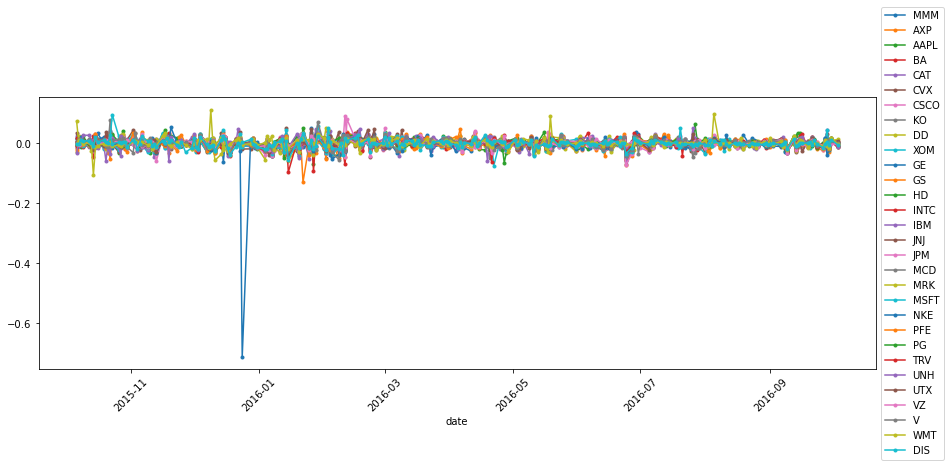

In [1]:
import pyreadr
import numpy as np
import matplotlib.pyplot as plt

djia_data = pyreadr.read_r('djia_data.RData')
close = djia_data['djia_close'].set_index('date')
log_return = np.log(close/close.shift(1))[1:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
log_return.plot(rot=45, style='.-', ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## (b) {-}

For the following analysis, we treat each company's time series as a data point. We take transpose of the data to stick to the convention that each row in the data matrix is an observation. 

In [2]:
log_return = log_return.T

The (Euclidean) distance matrix of the data can be computed by ```scipy.spatial.distance_matrix```. Here is a heat map of the computed matrix. There is a clear outlier that's far from all other data points due to the Nike stock split. 

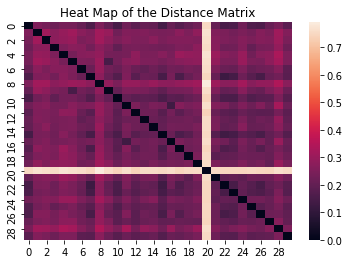

In [3]:
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(distance_matrix(log_return, log_return))
ax.set(title='Heat Map of the Distance Matrix')
plt.show()

If the below dendrogram is cut at 0.33, the stocks can roughly be put into 3 clusters, one of which being the outlier. The reasoning behind this choice is that if the tree is cut at a lower distance, say 0.3, we start to see "clusters" that only has one stock, like DD and AXP. 

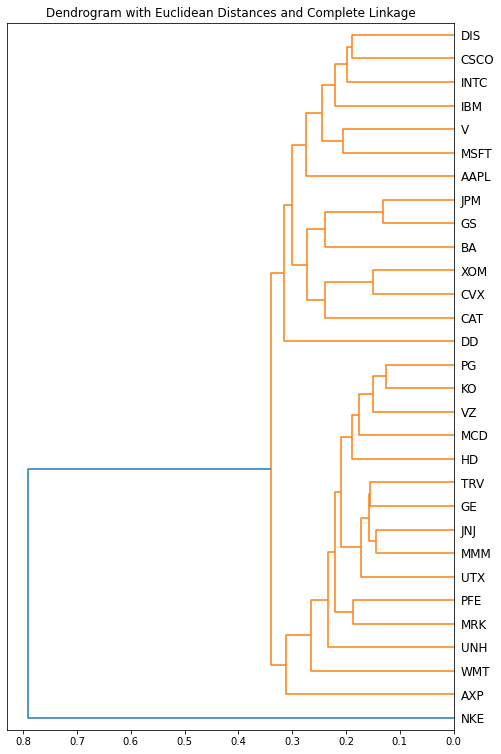

In [4]:
from scipy.cluster import hierarchy

hclust_complete = hierarchy.linkage(log_return, method='complete')

fig, ax = plt.subplots(1, 1, figsize=(8, 13))
hierarchy.dendrogram(hclust_complete, ax=ax, orientation='left', labels=log_return.index, leaf_font_size=12)
ax.set(title='Dendrogram with Euclidean Distances and Complete Linkage')
plt.show()

## (c) {-}

Below summarizes the clustering results of the companies and the corresponding industry. The outlier Nike is itself a cluster which makes sense. Roughly speaking, the rest two groups are the companies that profits directly from our daily consumption (Group #0), and the ones that are less related to our day-to-day life (Group #1). 

In [5]:
from scipy import cluster
from pandas import DataFrame
from scipy.spatial.distance import pdist

Z = cluster.hierarchy.complete(pdist(log_return))
cutree = cluster.hierarchy.cut_tree(Z, n_clusters=[3])

comp = djia_data['djia'][['Company', 'Industry']]
comp = comp.assign(Ticker=log_return.index, Group=cutree)
comp.sort_values(by=['Group', 'Industry']).reset_index(drop=True)

,Company,Industry,Ticker,Group
0,Coca-Cola,Beverages,KO,0
1,3M,Conglomerate,MMM,0
2,General Electric,Conglomerate,GE,0
3,United Technologies,Conglomerate,UTX,0
4,American Express,Consumer finance,AXP,0
5,Procter & Gamble,Consumer goods,PG,0
6,McDonald's,Fast food,MCD,0
7,The Home Depot,Home improvement retailer,HD,0
8,Travelers,Insurance,TRV,0
9,UnitedHealth Group,Managed health care,UNH,0


## (d) {-}

We draw the dendrogram with single linkage here. It does not give a good clustering results like complete linkage. 

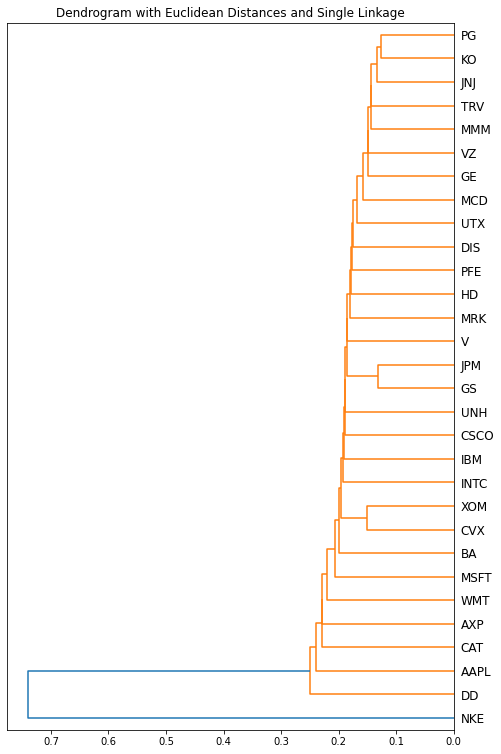

In [6]:
from scipy.cluster import hierarchy

hclust_complete = hierarchy.linkage(log_return, method='single')

fig, ax = plt.subplots(1, 1, figsize=(8, 13))
hierarchy.dendrogram(hclust_complete, ax=ax, orientation='left', labels=log_return.index, leaf_font_size=12)
ax.set(title='Dendrogram with Euclidean Distances and Single Linkage')
plt.show()

## (e) {-}

Now we replace the Euclidean distance by the correlation between the log return of stocks and run the experiment again. 

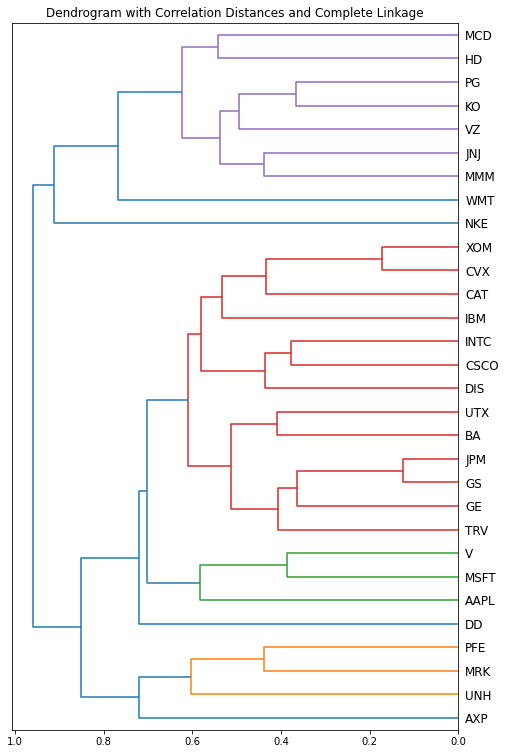

In [7]:
from scipy.cluster import hierarchy

hclust_complete = hierarchy.linkage(log_return, method='complete', metric='correlation')

fig, ax = plt.subplots(1, 1, figsize=(8, 13))
hierarchy.dendrogram(hclust_complete, ax=ax, orientation='left', labels=log_return.index, leaf_font_size=12)
ax.set(title='Dendrogram with Correlation Distances and Complete Linkage')
plt.show()

The results are similar to the above: The outlier Nike is still by itself in Group #3. Group #0 and Group #1 are collections of companies whose profit ties directly to our daily consumption and the rest are in Group #2. 

In [8]:
from scipy import cluster
from pandas import DataFrame
from scipy.spatial.distance import pdist

Z = cluster.hierarchy.complete(pdist(log_return, metric='correlation'))
cutree = cluster.hierarchy.cut_tree(Z, n_clusters=[4])

comp = djia_data['djia'][['Company', 'Industry']]
comp = comp.assign(Ticker=log_return.index, Group=cutree)
comp.sort_values(by=['Group', 'Industry']).reset_index(drop=True)

,Company,Industry,Ticker,Group
0,Coca-Cola,Beverages,KO,0
1,3M,Conglomerate,MMM,0
2,Procter & Gamble,Consumer goods,PG,0
3,McDonald's,Fast food,MCD,0
4,The Home Depot,Home improvement retailer,HD,0
5,Johnson & Johnson,Pharmaceuticals,JNJ,0
6,Wal-Mart,Retail,WMT,0
7,Verizon,Telecommunication,VZ,0
8,American Express,Consumer finance,AXP,1
9,UnitedHealth Group,Managed health care,UNH,1


## (f) {-}

Next we replace the distance by Spearman's correlation, which can be computed by ```scipy.stats.spearmanr```. Since it is robust to outliers, Nike is finally not isolated. 

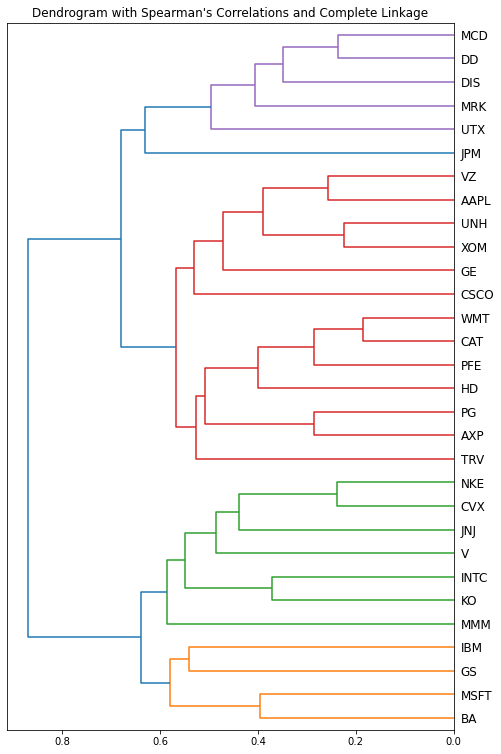

In [10]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

hclust_complete = hierarchy.linkage(log_return, method='complete', metric=lambda a, b: spearmanr(a, b)[0])

fig, ax = plt.subplots(1, 1, figsize=(8, 13))
hierarchy.dendrogram(hclust_complete, ax=ax, orientation='left', labels=log_return.index, leaf_font_size=12)
ax.set(title="Dendrogram with Spearman's Correlations and Complete Linkage")
plt.show()

In [14]:
from scipy import cluster
from pandas import DataFrame
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist

Z = cluster.hierarchy.complete(pdist(log_return, metric=lambda a, b: spearmanr(a, b)[0]))
cutree = cluster.hierarchy.cut_tree(Z, n_clusters=[4])

comp = djia_data['djia'][['Company', 'Industry']]
comp = comp.assign(Ticker=log_return.index, Group=cutree)
comp.sort_values(by=['Group', 'Industry']).reset_index(drop=True)

,Company,Industry,Ticker,Group
0,Nike,Apparel,NKE,0
1,Coca-Cola,Beverages,KO,0
2,3M,Conglomerate,MMM,0
3,Visa,Consumer banking,V,0
4,Chevron,Oil & gas,CVX,0
5,Johnson & Johnson,Pharmaceuticals,JNJ,0
6,Intel,Semiconductors,INTC,0
7,Cisco Systems,Computer networking,CSCO,1
8,General Electric,Conglomerate,GE,1
9,Caterpillar,Construction and mining equipment,CAT,1


# 3. {-}

## (a) (b) {-}

Below we run the clustering with the Euclidean and the tangent distances, respectively, with the complete linkage. We then cut the dendrogram to form 3 and 6 clusters for each distance metrics. The clustering results (group indices) are put together with the labels of the training data in a sorted table. In the end we present a heat map of the table, where the column ```x``` is the label, ```group3``` and ```group6``` are the 3-group and 6-group results by the Euclidean distances, respectively, and ```group3_tan``` and ```group6_tan``` are the 3-group and 6-group results by the tangent distances, respectively. 

Any row where the corresponding ```x``` column is black is a flattened image of 0. If the corresponding ```x``` column is purple, the row is a flattened image of 1, and if it is pink, the row is a flattened image of 4. As shown in the heat map, the clustering with the Euclidean distances can not distinguish 1 and 4. Almost all 1's and 4's in the ```group3``` and ```group6``` columns are in the same color purple (indicating same cluster). We also see the same issue with the 3-group results with the tangent distances. But the 6-group results with the tangent distances are better. In the ```group6_tan``` column, most of the 4's are black. Only a small part is purple, where the algorithm fails to be separate them from 1's. 

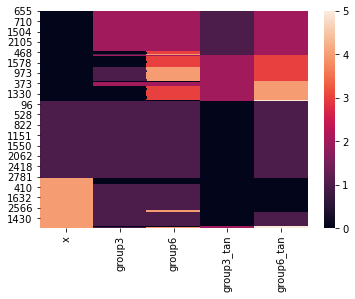

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
import pyreadr

tan_dist = pyreadr.read_r('tangent_distances.RData')['tangentDist']
X = pd.read_csv('x_014_tr.csv', index_col=0)
y = pd.read_csv('y_014_tr.csv', index_col=0)

Z = hierarchy.complete(pdist(X, metric='euclidean'))
Z_tan = hierarchy.complete(tan_dist.values.flatten())

cutree3 = hierarchy.cut_tree(Z, n_clusters=[3])
cutree6 = hierarchy.cut_tree(Z, n_clusters=[6])
cutree3_tan = hierarchy.cut_tree(Z_tan, n_clusters=[3])
cutree6_tan = hierarchy.cut_tree(Z_tan, n_clusters=[6])

y = y.assign(   group3=cutree3.flatten(), 
                group6=cutree6.flatten(), 
                group3_tan=cutree3_tan.flatten(), 
                group6_tan=cutree6_tan.flatten())

y.sort_values(by=['x', 'group6_tan', 'group6', 'group3_tan', 'group3'], inplace=True)
sns.heatmap(y)
plt.show()

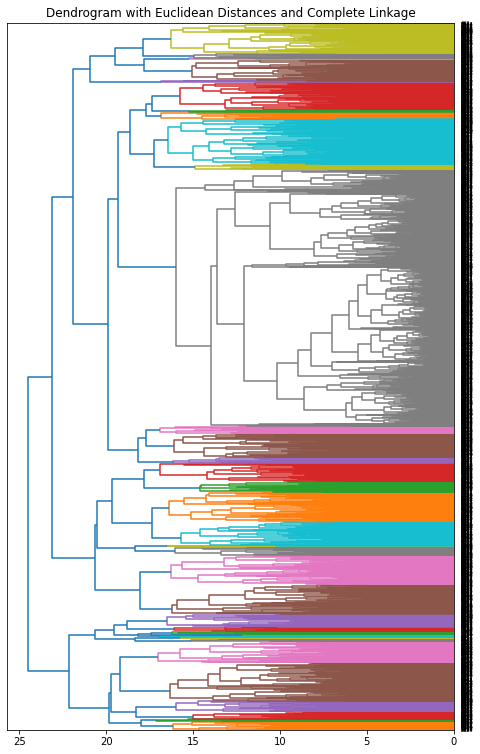

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
hierarchy.dendrogram(Z, ax=ax, orientation='left')
ax.set(title='Dendrogram with Euclidean Distances and Complete Linkage')
plt.show()

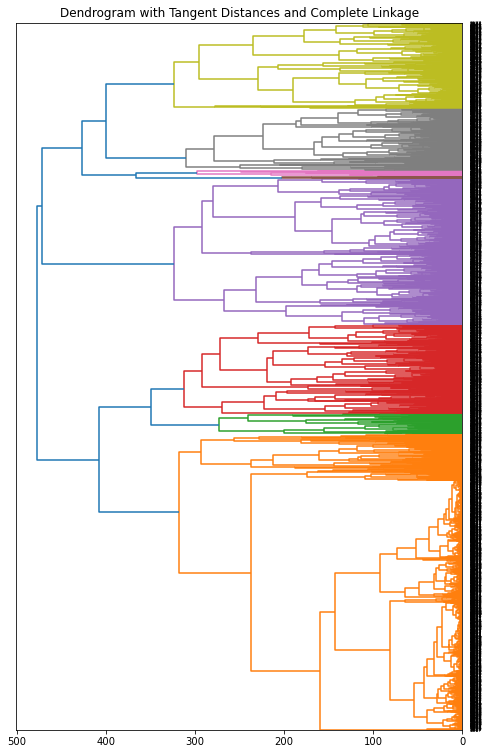

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
hierarchy.dendrogram(Z_tan, ax=ax, orientation='left')
ax.set(title='Dendrogram with Tangent Distances and Complete Linkage')
plt.show()

## (d) {-}

Below are the complete linkage cluster centroids, presented as images. The sign of the original data is flipped for a better visualization. 

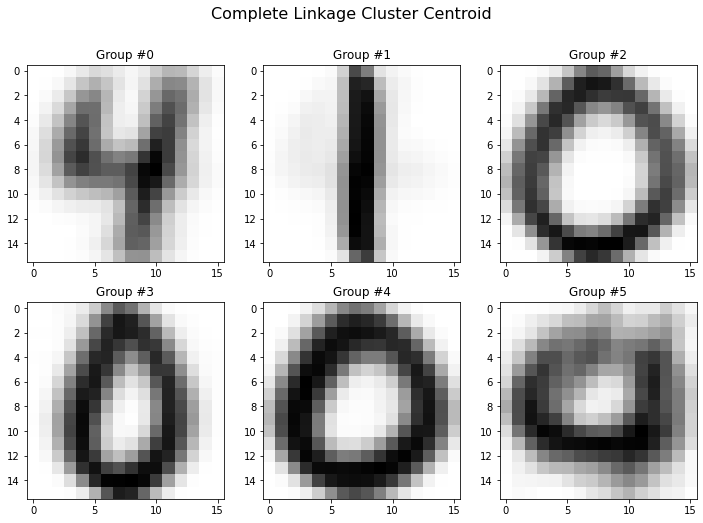

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for (group, df), ax in zip(y.groupby('group6_tan'), axs.ravel()):
    image = -X.loc[df.index].mean(axis='index').values.reshape(16, 16)
    ax.imshow(image, cmap='gray')
    ax.set(title='Group #%d'% group)

plt.suptitle('Complete Linkage Cluster Centroid', fontsize=16)
plt.show()